# 对服装图像进行分类

本指南将训练一个神经网络模型，对运动鞋和衬衫等服装图像进行分类。即使您不理解所有细节也没关系；这只是对完整 TensorFlow 程序的快速概述，详细内容会在您实际操作的同时进行介绍。

本指南使用了 `tf.keras`，它是 TensorFlow 中用来构建和训练模型的高级 API。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


## 导入 Fashion MNIST 数据集

本指南使用 `Fashion MNIST` 数据集，该数据集包含 10 个类别的 70,000 个灰度图像。这些图像以低分辨率（28x28 像素）展示了单件衣物，如下所示：

![](https://tensorflow.google.cn/images/fashion-mnist-sprite.png?hl=zh-cn)

Fashion MNIST 旨在临时替代经典 `MNIST` 数据集，后者常被用作计算机视觉机器学习程序的“Hello, World”。MNIST 数据集包含手写数字（0、1、2 等）的图像，其格式与您将使用的衣物图像的格式相同。

本指南使用 Fashion MNIST 来实现多样化，因为它比常规 MNIST 更具挑战性。这两个数据集都**相对较小**，都用于验证某个算法是否按预期工作。对于代码的测试和调试，它们都是很好的起点。

在本指南中，我们使用 60,000 个图像来训练网络，使用 10,000 个图像来评估网络学习对图像分类的准确率。您可以直接从 TensorFlow 访问 Fashion MNIST。请运行以下代码，直接从 TensorFlow 中导入和加载 Fashion MNIST 数据：

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

加载数据集会返回四个 NumPy 数组：
- `train_images` 和 `train_labels` 数组是*训练集*，即模型用于学习的数据。
- *测试集*、`test_images` 和 `test_labels` 数组会被用来对模型进行测试。

图像是 28x28 的 NumPy 数组，像素值介于 0 到 255 之间。标签是整数数组，介于 0 到 9 之间。这些标签对应于图像所代表的服装类：

|标签|类|
|---|---|
|0|T恤/上衣|
|1|裤子|
|2|套头衫|
|3|连衣裙|
|4|外套|
|5|凉鞋|
|6|衬衫|
|7|运动鞋|
|8|包|
|9|短靴|

每个图像都会被映射到一个标签。由于数据集不包括类名称，请将它们存储在下方，供稍后绘制图像时使用：

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 浏览数据

在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：

In [4]:
train_images.shape

(60000, 28, 28)

同样，训练集中有 60,000 个标签：

In [5]:
len(train_labels)

60000

每个标签都是一个 0 到 9 之间的整数：

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

测试集中有 10,000 个图像。同样，每个图像都由 28x28 个像素表示：

In [7]:
test_images.shape

(10000, 28, 28)

测试集包含 10,000 个图像标签：

In [8]:
len(test_labels)

10000

## 预处理数据 

在训练网络之前，必须对数据进行预处理。如果您检查训练集中的第一个图像，您会看到像素值处于 0 到 255 之间：


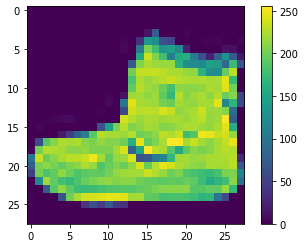

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

将这些值缩小至 0 到 1 之间，然后将其馈送到神经网络模型。为此，请将这些值除以 255。请务必以相同的方式对训练集和测试集进行预处理：

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

为了验证数据的格式是否正确，以及您是否已准备好构建和训练网络，让我们显示训练集中的前 25 个图像，并在每个图像下方显示类名称。

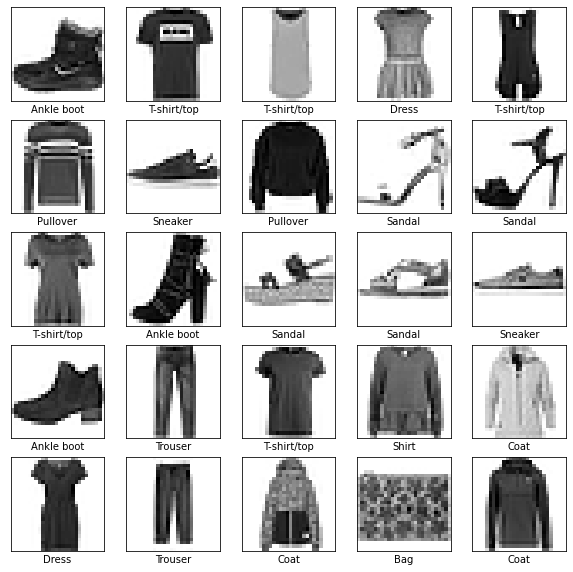

In [11]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]) # 去掉 xtick
    plt.yticks([]) # 去掉 y-ticks
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 构建模型

构建神经网络需要先配置模型的层，然后再编译模型。

### 设置层

神经网络的基本组成部分是层。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。

大多数深度学习都包括将简单的层链接在一起。大多数层（如 `tf.keras.layers.Dense`）都具有在训练期间才会学习的参数。


In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])


该网络的第一层 `tf.keras.layers.Flatten` 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。

展平像素后，网络会包括两个 `tf.keras.layers.Dense` 层的序列。它们是密集连接或全连接神经层。第一个 Dense 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

### 编译模型

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：
- *损失函数* - 用于测量模型在训练期间的准确率。您会希望最小化此函数，以便将模型“引导”到正确的方向上。
- *优化器* - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
- *指标* - 用于监控训练和测试步骤。以下示例使用了**准确率**，即被正确分类的图像的比率。


In [13]:
model.compile(optimizer='adam',
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

## 训练模型

训练神经网络模型需要执行以下步骤：

1. 将训练数据提交给模型。在本例中，训练数据为 `train_images` 和 `train_labels` 数组。
2. 模型学习将图像和标签关联起来。
3. 模型对测试集（在本例中为 `test_images` 数组）进行预测。
4. 验证预测结果是否与 `test_labels` 数组中的标签一致。

### 向模型馈送数据

要开始训练，请调用 `model.fit` 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [15]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 655us/step - loss: 0.6273 - accuracy: 0.7816
Epoch 2/10
1875/1875 [==============================] - 1s 657us/step - loss: 0.3897 - accuracy: 0.8584
Epoch 3/10
1875/1875 [==============================] - 1s 632us/step - loss: 0.3416 - accuracy: 0.8762
Epoch 4/10
1875/1875 [==============================] - 1s 655us/step - loss: 0.3091 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 1s 630us/step - loss: 0.2954 - accuracy: 0.8908
Epoch 6/10
1875/1875 [==============================] - 1s 648us/step - loss: 0.2793 - accuracy: 0.8963
Epoch 7/10
1875/1875 [==============================] - 1s 646us/step - loss: 0.2731 - accuracy: 0.8988
Epoch 8/10
1875/1875 [==============================] - 1s 640us/step - loss: 0.2621 - accuracy: 0.9031
Epoch 9/10
1875/1875 [==============================] - 1s 656us/step - loss: 0.2456 - accuracy: 0.9070
Epoch 10/10
1875/1875 [==============================] - 1s 641u

在模型训练期间，会显示损失和准确率指标。此模型在训练数据上的准确率达到了 0.91（或 91%）左右。

### 评估准确率

接下来，比较模型在测试数据集上的表现：

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print("\nTest accuracy:", test_acc)

313/313 - 0s - loss: 0.3312 - accuracy: 0.8837

Test accuracy: 0.8837000131607056


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表*过拟合*。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。

### 进行预测

在模型经过训练后，您可以使用它对一些图像进行预测。模型具有线性输出，即 logits。您可以附加一个 softmax 层，将 logits 转换成更容易理解的概率。


In [17]:
probability_model = keras.Sequential([model, keras.layers.Softmax()])

In [27]:
predictions = probability_model.predict(test_images)

在上例中，模型预测了测试集中每个图像的标签。我们来看看第一个预测结果：

In [28]:
predictions[0]

array([8.5481992e-07, 8.2990802e-12, 6.0343824e-10, 5.4718248e-12,
       5.5994573e-09, 1.1489919e-03, 1.4696269e-06, 5.2378182e-03,
       1.4898801e-08, 9.9361080e-01], dtype=float32)

预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。您可以看到哪个标签的置信度值最大：

In [29]:
np.argmax(predictions[0])

9

因此，该模型非常确信这个图像是短靴，或 `class_names[9]`。通过检查测试标签发现这个分类是正确的：

In [21]:
test_labels[0]

9

您可以将其绘制成图表，看看模型对于全部 10 个类的预测。

In [30]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 验证预测结果

在模型经过训练后，您可以使用它对一些图像进行预测。

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

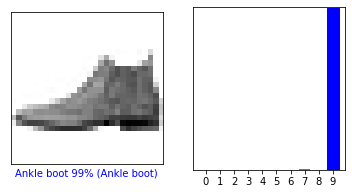

In [31]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

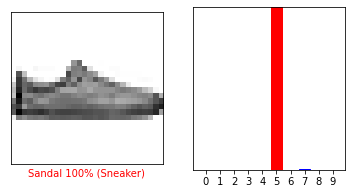

In [32]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

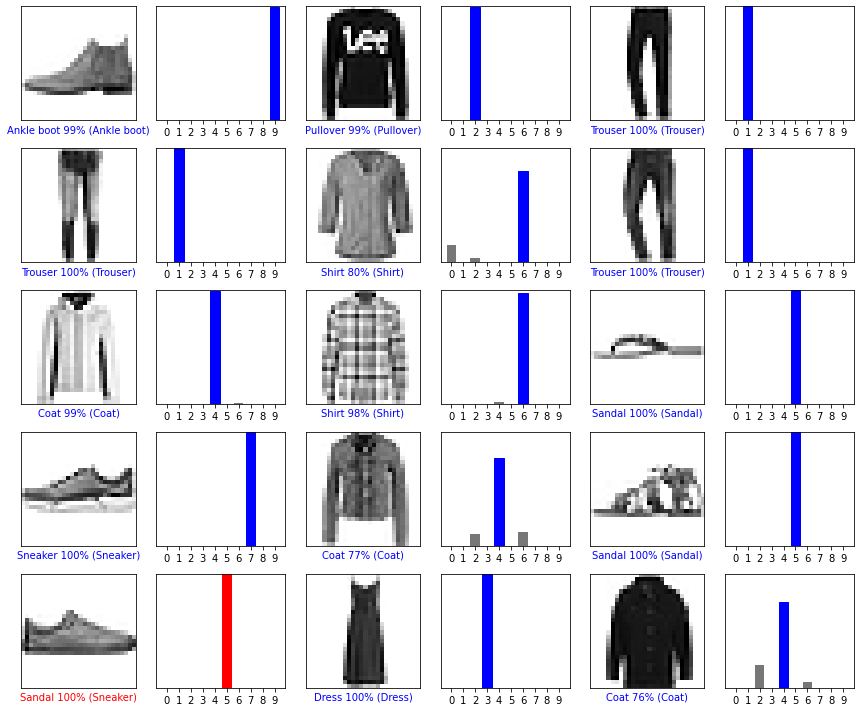

In [33]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predicitions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predicitions[i], test_labels)
plt.tight_layout()
plt.show()